In [39]:
import numpy as np
import matplotlib.pyplot as plt
from h5py import File

from astropy.cosmology import FlatLambdaCDM
from interpax import Interpolator2D

import jax.numpy as jnp
from jax import random

import numpyro
from numpyro import sample, plate, factor
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_sample
from numpyro.infer import Predictive

from candel import SPEED_OF_LIGHT, plot_corner

%matplotlib inline

### CF4 data

In [41]:
with File("/Users/rstiskalek/Projects/CANDEL/data/CF4/CF4_GroupAll.hdf5", 'r') as f:
    mu = f["DMzp"][...]
    e_mu = f["eDM"][...]
    z_cmb = f["Vcmb"][...] / SPEED_OF_LIGHT


m = e_mu > 0
print(f"Removing {np.sum(~m)} objects with zero uncertainty.")
mu, e_mu, z_cmb = mu[m], e_mu[m], z_cmb[m]

low, high = 0.001, 0.05
m = (z_cmb > low) & (z_cmb < high)
print(f"Selecting objects with redshift in range [{low}, {high}], {np.sum(m)} objects selected and {np.sum(~m)} objects removed.")
mu, e_mu, z_cmb = mu[m], e_mu[m], z_cmb[m]

print(f"Assigning redshift error of 300 km / s for all objects.")
zcmb_err = 300 / SPEED_OF_LIGHT 
zcmb_err = np.full_like(z_cmb, zcmb_err)

print(f"Maximum redshift: {np.max(z_cmb)}")

Removing 228 objects with zero uncertainty.
Selecting objects with redshift in range [0.001, 0.05], 18143 objects selected and 19686 objects removed.
Assigning redshift error of 300 km / s for all objects.
Maximum redshift: 0.049997922229251014


### Redshift to distance modulus mapping

In [42]:
class Redshift2Distmod:
    """
    Interpolator to convert redshift and Omega_matter to distance modulus.
    """
    def __init__(self, zmin=1e-5, zmax=0.15, nz=3000,
                 Om_min=0.01, Om_max=0.99, nOm=3000, method='cubic'):
        self.z_grid = np.linspace(zmin, zmax, nz)
        self.Om_grid = np.linspace(Om_min, Om_max, nOm)

        # Precompute distance modulus grid
        mu_grid = np.empty((nz, nOm))
        for j, Om in enumerate(self.Om_grid):
            cosmo = FlatLambdaCDM(H0=100, Om0=Om)
            mu_grid[:, j] = cosmo.distmod(self.z_grid).value

        # Build the interpolator: f(z, Om) -> mu
        self._interp = Interpolator2D(
            x=jnp.asarray(self.z_grid),
            y=jnp.asarray(self.Om_grid),
            f=jnp.asarray(mu_grid),
            method=method,
            extrap=False,
        )

    def __call__(self, z, Om, h):
        """
        Evaluate distance modulus at given redshift(s) and Omega_matter(s).
        """
        return self._interp(z, Om) - 5 * jnp.log10(h)

### Probabilistic model

In [59]:
def model(z_cmb, z_cmb_err, mu, e_mu, redshift2distmod_interp):
    """
    NumPyro model to fit distance modulus data with cosmological parameters.
    """
    Om = sample("Om", dist.Uniform(0.05, 0.95))
    h = sample("h", dist.Uniform(0.1, 1.0))

    # z_mean = sample("z_mean", dist.Uniform(0.0, 0.2))
    # z_std = sample("z_std", dist.Uniform(0.0, 0.1))

    with plate("redshift", len(z_cmb)):
        z_true = sample("z_true", dist.Uniform(0.0, 0.11))

    # with plate("ll_redshift", len(z_cmb)):
    factor("ll_cz", dist.Normal(z_true, z_cmb_err).log_prob(z_cmb))

    mu_model = redshift2distmod_interp(z_true, Om, h)
    # mu_model = redshift2distmod_interp(z_cmb, Om, h)

    e_mu_intrinsic = sample("e_mu_intrinsic", dist.Uniform(0.01, 2.0))
    factor("ll_e_mu", -jnp.log(e_mu_intrinsic))
    e_mu_total = jnp.sqrt(e_mu**2 + e_mu_intrinsic**2)

    with plate("data", len(z_cmb)):
        sample("mu", dist.Normal(mu_model, e_mu_total), obs=mu)


In [60]:
redshift2distmod = Redshift2Distmod()
kernel = NUTS(model, init_strategy=init_to_sample())

# Set up and run MCMC
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=1)
mcmc.run(random.PRNGKey(0),
         z_cmb=z_cmb,
         z_cmb_err=zcmb_err,
         mu=mu,
         e_mu=e_mu,
         redshift2distmod_interp=redshift2distmod)

mcmc.print_summary()
samples = mcmc.get_samples()
# samples["q0"] = samples["Om"] / 2 - (1 - samples["Om"])

sample: 100%|██████████| 1000/1000 [02:44<00:00,  6.07it/s, 127 steps of size 3.89e-02. acc. prob=0.81]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
              Om      0.82      0.09      0.84      0.69      0.95    298.57      1.00
  e_mu_intrinsic      0.02      0.01      0.01      0.01      0.03    228.61      1.00
               h      0.74      0.00      0.74      0.74      0.75    264.59      1.00
       z_true[0]      0.02      0.00      0.02      0.02      0.02    823.50      1.00
       z_true[1]      0.04      0.00      0.04      0.04      0.04    513.29      1.00
       z_true[2]      0.02      0.00      0.02      0.02      0.02    918.90      1.00
       z_true[3]      0.02      0.00      0.02      0.01      0.02   1054.74      1.00
       z_true[4]      0.03      0.00      0.03      0.03      0.03   1059.51      1.00
       z_true[5]      0.02      0.00      0.02      0.02      0.03    792.32      1.00
       z_true[6]      0.02      0.00      0.02      0.02      0.02   1082.80      1.00
       z_true[7]      0.04      0.00      

In [61]:
samples.keys()
samples.pop("z_true", None)

Array([[0.02071982, 0.03760096, 0.01835842, ..., 0.04916523, 0.04913243,
        0.02361971],
       [0.01881927, 0.03685172, 0.01988213, ..., 0.04998449, 0.04875682,
        0.02247117],
       [0.02080522, 0.03683468, 0.02092334, ..., 0.04899067, 0.05035024,
        0.02206944],
       ...,
       [0.02143523, 0.03728734, 0.01782392, ..., 0.04881553, 0.05016284,
        0.02286345],
       [0.02038119, 0.03894128, 0.01787701, ..., 0.05018325, 0.04936558,
        0.0235185 ],
       [0.02181559, 0.03750031, 0.0184142 , ..., 0.04840422, 0.05122167,
        0.02324417]], dtype=float32)

2025-05-30 15:08:20 saving a corner plot to corner_CF4.png


/Users/rstiskalek/Projects/CANDEL/candel/util.py:313: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


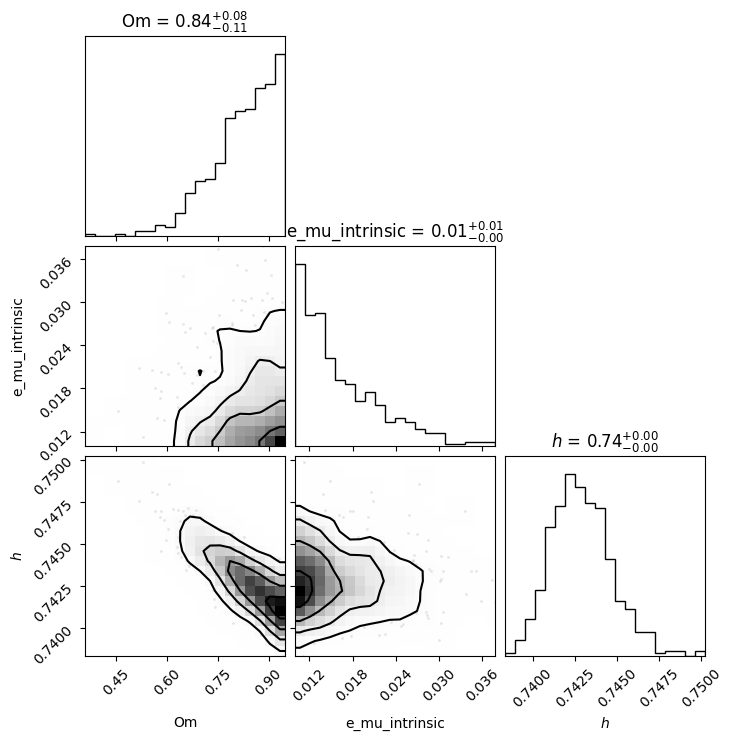

In [62]:
plot_corner(samples, filename="corner_CF4.png",)

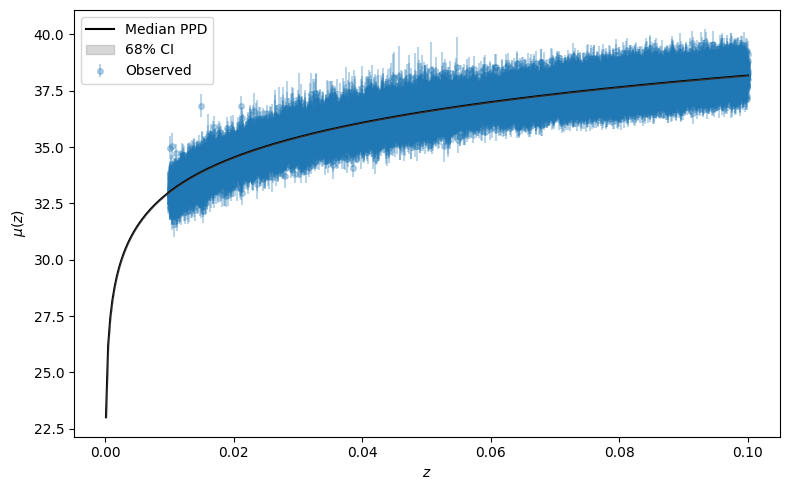

In [35]:
# Define evaluation redshift grid
z_grid = np.linspace(0.0001, z_cmb.max(), 300)

# Stack samples
Om_samples = samples["Om"]
h_samples = samples["h"]

# Compute mu(z) for each sample over the z_grid
mu_grid = np.stack([
    redshift2distmod(z_grid, Om, h)
    for Om, h in zip(Om_samples, h_samples)
])

# Compute percentiles across samples
mu_median = np.median(mu_grid, axis=0)
mu_lo, mu_hi = np.percentile(mu_grid, [16, 84], axis=0)

# Sort observed data for cleaner overlay
idx = np.argsort(z_cmb)
z_obs_sorted = z_cmb[idx]
mu_obs_sorted = mu[idx]
e_mu_sorted = e_mu[idx]

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(z_obs_sorted, mu_obs_sorted, yerr=e_mu_sorted,
             fmt='o', markersize=4, alpha=0.3, label="Observed", zorder=0)
plt.plot(z_grid, mu_median, label="Median PPD", color="k", zorder=1)
plt.fill_between(z_grid, mu_lo, mu_hi, alpha=0.3, color="gray", label="68% CI", zorder=1)
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu(z)$")
plt.legend()
plt.tight_layout()
plt.savefig("CF4_mu_vs_z_PPD.png", dpi=300)
plt.show()